<a href="https://colab.research.google.com/github/maidaly/Hotels_reviews_sentiment_analysis_flask_web-app/blob/main/Hotels_reviews_sentiment_analysis_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install -q kaggle
!mkdir ~/.kaggle
from google.colab import files
files.upload()

In [2]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d jiashenliu/515k-hotel-reviews-data-in-europe

 82% 37.0M/45.1M [00:00<00:00, 206MB/s]
100% 45.1M/45.1M [00:00<00:00, 212MB/s]


In [3]:
!unzip 515k-hotel-reviews-data-in-europe.zip

unzip:  cannot find or open 515k-hotel-reviews-data-in-europe.zip, 515k-hotel-reviews-data-in-europe.zip.zip or 515k-hotel-reviews-data-in-europe.zip.ZIP.


### Imports

In [1]:
import os
import nltk
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
plt.style.use('ggplot')
warnings.simplefilter('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Read data

In [2]:
df = pd.read_csv("515k-hotel-reviews-data-in-europe.zip")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

In [4]:
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


### Select reviews data

In [5]:
intersted_cols = df[['Negative_Review', 'Positive_Review']]

In [6]:
Negative_Reviews = intersted_cols[intersted_cols['Negative_Review'] != "No Negative"]['Negative_Review'].reset_index(drop=True)
Positive_Reviews = intersted_cols[intersted_cols['Positive_Review'] != "No Positive"]['Positive_Review'].reset_index(drop=True)

In [7]:
labels=[0.0] * len(Negative_Reviews) + [1.0] * len(Positive_Reviews)
reviews = np.concatenate([Negative_Reviews.values,Positive_Reviews.values])
reviews_data = pd.DataFrame({"review":reviews, "label": labels})

In [8]:
reviews_data.head()

,review,label
0,I am so angry that i made this post available...,0.0
1,Rooms are nice but for elderly a bit difficul...,0.0
2,My room was dirty and I was afraid to walk ba...,0.0
3,You When I booked with your company on line y...,0.0
4,Backyard of the hotel is total mess shouldn t...,0.0


### EDA

Text(0.5, 1.0, 'labels distrbution')

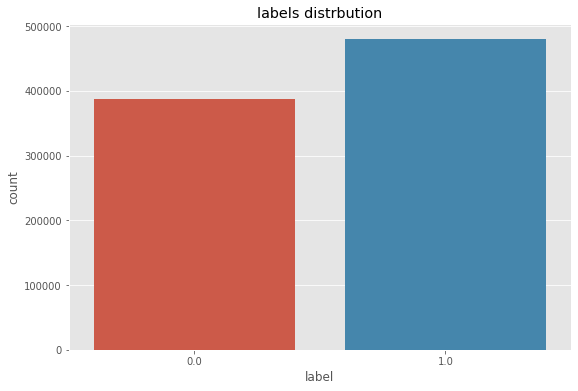

In [9]:
plt.figure(figsize=(9, 6))
sns.countplot(reviews_data['label'])
plt.title('labels distrbution')

### Text Cleaning

In [10]:
stop_words = stopwords.words('english')

def tokenize(text_string):
    return word_tokenize(text_string)

def remove_punct(text):
    text  = [''.join(filter( lambda x: x in 'abcdefghijklmnopqrstuvwxyz', word.lower()))
             for word in text]
    return text

def remove_stopwords(text):
    text = [word for word in text if word not in stop_words]
    return text


def stemming(text):
    stemm = nltk.PorterStemmer()
    text = [stemm.stem(word) for word in text]
    return text


def lemmatizer(text):
    lemm = nltk.WordNetLemmatizer()
    text = [lemm.lemmatize(word) for word in text]
    return text

def clean_text(text):
    text = tokenize(text)
    text = remove_punct(text)
    text = remove_stopwords(text)
    # text = stemming(text)
    return ' '.join(text)

In [11]:
reviews_data['clean_review'] = reviews_data['review'].progress_map(lambda x:clean_text(x))

100%|██████████| 867640/867640 [04:10<00:00, 3470.47it/s]


### Feature Extraction with TFIDF


I selected only 200000 samples to prevent the notebook from crashed due to exceeding the available ram usage. 

In [12]:
tfidf = TfidfVectorizer(max_df= 0.6, min_df=5, max_features=10000)
X_train, X_text, y_train, y_test = train_test_split(reviews_data['clean_review'], reviews_data['label'], test_size=0.2, shuffle=True)
X_train_tfidf = tfidf.fit_transform(X_train[:150000]).toarray()
X_test_tfidf = tfidf.transform(X_text)

### LogisticRegression model

In [16]:
lr = LogisticRegression()
lr.fit(X_train_tfidf,y_train[:150000])


In [18]:
y_pred = lr.predict(X_test_tfidf)
print(f"LogisticRegression model accuracy {format(accuracy_score(y_test,y_pred), '.2f')}")

LogisticRegression model accuracy 0.92


In [14]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92     77449
         1.0       0.94      0.92      0.93     96079

    accuracy                           0.92    173528
   macro avg       0.92      0.93      0.92    173528
weighted avg       0.93      0.92      0.92    173528



#### Confusion Matrix

Text(0.5, 1.0, 'Logistic regression model Confusion Matrix')

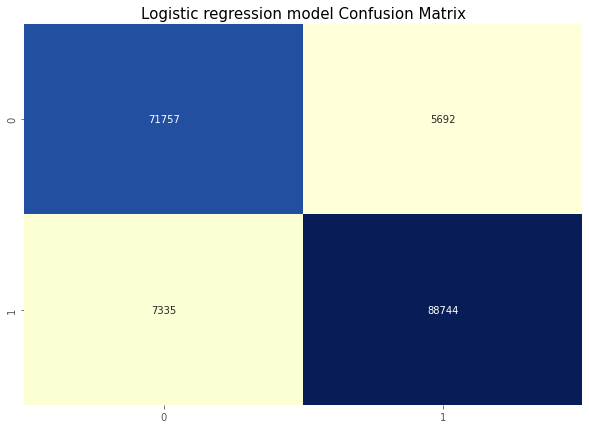

In [15]:
con_mat = confusion_matrix(np.array(y_test), y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(con_mat, annot=True,fmt="d", cmap="YlGnBu", cbar=False)
plt.title("Logistic regression model Confusion Matrix", size=15)